In [1]:
# !sudo apt install swig

In [2]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [3]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "UL", "XOM"
]
START_DATE = '2011-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()
portfolio_raw_df
portfolio_raw_df.groupby("tic").count()

combined_spy_vix_fear_greed = pd.read_csv('spy_vix_fear_greed_2011_2023.csv')


portfolio_raw_df['date'] = pd.to_datetime(portfolio_raw_df['date'])
combined_spy_vix_fear_greed['Date'] = pd.to_datetime(combined_spy_vix_fear_greed['Date'])


df_portfolio_comb = pd.merge(portfolio_raw_df, combined_spy_vix_fear_greed, left_on='date', right_on='Date', how='left')


df_portfolio_comb = df_portfolio_comb.drop(columns=['Date'])
df_portfolio_comb['date'] = df_portfolio_comb['date'].dt.strftime('%Y-%m-%d')

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (32700, 8)


In [5]:
FMP_historical_ratings = pd.read_csv('FMP_historical_ratings.csv')

df_portfolio_comb_2 = df_portfolio_comb.merge(
    FMP_historical_ratings[['date', 'symbol', 'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore']],
    left_on=['date', 'tic'],
    right_on=['date', 'symbol'],
    how='left' )

df_portfolio_comb_2.drop(columns=['symbol'], inplace=True)
df_portfolio_comb_2.head()

,date,open,high,low,close,volume,tic,day,Open_VIX,High_VIX,...,Close_SPY,Adj Close_SPY,Volume_SPY,Fear Greed,ratingScore,ratingDetailsDCFScore,ratingDetailsROEScore,ratingDetailsROAScore,ratingDetailsPEScore,ratingDetailsPBScore
0,2011-01-03,11.630000,11.795000,11.601429,9.939776,445138400,AAPL,0,17.940001,17.950001,...,127.050003,98.665207,138725200,68.0,4.0,5.0,3.0,3.0,4.0,4.0
1,2011-01-03,91.660004,92.379997,91.300003,53.133175,7802300,CVX,0,17.940001,17.950001,...,127.050003,98.665207,138725200,68.0,3.0,4.0,3.0,3.0,1.0,1.0
2,2011-01-03,170.550003,173.250000,169.850006,135.215973,5717100,GS,0,17.940001,17.950001,...,127.050003,98.665207,138725200,68.0,3.0,5.0,3.0,3.0,1.0,1.0
3,2011-01-03,62.630001,63.180000,62.529999,42.221142,14894800,JNJ,0,17.940001,17.950001,...,127.050003,98.665207,138725200,68.0,4.0,4.0,3.0,3.0,5.0,5.0
4,2011-01-03,43.000000,44.040001,42.959999,29.947800,43278500,JPM,0,17.940001,17.950001,...,127.050003,98.665207,138725200,68.0,4.0,4.0,3.0,3.0,5.0,4.0


In [6]:
# Filling NaN values with 0
df_portfolio_comb_2.fillna(0, inplace=True)

In [7]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_comb_2)
portfolio_norm_df
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low",'High_VIX','Low_VIX','Close_VIX','High_SPY',
                                'Low_SPY','Close_SPY','Volume_SPY','Fear Greed', 'ratingScore','ratingDetailsDCFScore',
                                  'ratingDetailsROEScore','ratingDetailsROAScore','ratingDetailsPEScore','ratingDetailsPBScore']]

C:\Users\limyi\myenv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.23665012 0.16431745 0.13584257 ... 0.02556499 0.01810204 0.02266286]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
C:\Users\limyi\myenv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
C:\Users\limyi\myenv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated 

In [8]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

In [9]:
df_portfolio_2023.head(50)

,date,tic,close,high,low,High_VIX,Low_VIX,Close_VIX,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Fear Greed,ratingScore,ratingDetailsDCFScore,ratingDetailsROEScore,ratingDetailsROAScore,ratingDetailsPEScore,ratingDetailsPBScore
30200,2023-01-03,AAPL,0.627807,0.655746,0.630305,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,1.0,1.0,1.00,1.00,1.0,1.0
30201,2023-01-03,CVX,0.926514,0.943695,0.921205,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,0.8,1.0,0.60,0.60,0.8,1.0
30202,2023-01-03,GS,0.842821,0.818003,0.828524,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,1.0,1.0,0.75,1.00,1.0,0.8
30203,2023-01-03,JNJ,0.976858,0.955488,0.955641,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,1.0,1.0,0.75,0.75,1.0,1.0
30204,2023-01-03,JPM,0.770457,0.790587,0.785094,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,1.0,1.0,1.00,1.00,0.8,1.0
30205,2023-01-03,MSFT,0.620523,0.639474,0.627777,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,1.0,1.0,1.00,1.00,1.0,1.0
30206,2023-01-03,PFE,0.864077,0.831794,0.849407,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,0.8,1.0,0.60,0.60,0.8,1.0
30207,2023-01-03,PG,0.940191,0.917508,0.912607,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,1.0,1.0,0.75,1.00,1.0,1.0
30208,2023-01-03,UL,0.863019,0.778532,0.779265,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,1.0,1.0,1.00,1.00,1.0,1.0
30209,2023-01-03,XOM,0.864687,0.911516,0.892546,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.104274,0.371134,1.0,1.0,1.00,0.75,0.8,1.0


In [10]:
input_features = ['high','low','close','High_VIX','Low_VIX','Close_VIX','Fear Greed',
                  'ratingScore','ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore','ratingDetailsPEScore','ratingDetailsPBScore']


environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=input_features,
        normalize_df=None
    )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "initial_features": len(input_features),
    "k_size": 4,
    "time_window": 50,
    "conv_mid_features":5,
    "conv_final_features":20}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [11]:
DRLAgent.train_model(model, episodes=5)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 926559.4375
Final accumulative portfolio value: 9.265594375
Maximum DrawDown: -0.3184236795123281
Sharpe ratio: 1.1681271469052639


 20%|████████████████▊                                                                   | 1/5 [01:07<04:31, 67.76s/it]

Initial portfolio value:100000
Final portfolio value: 1469298.375
Final accumulative portfolio value: 14.69298375
Maximum DrawDown: -0.38947630237283914
Sharpe ratio: 1.2111858082648146


 40%|█████████████████████████████████▌                                                  | 2/5 [02:22<03:35, 71.94s/it]

Initial portfolio value:100000
Final portfolio value: 2245411.75
Final accumulative portfolio value: 22.4541175
Maximum DrawDown: -0.3667421993381629
Sharpe ratio: 1.3549311517522313


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:33<02:22, 71.33s/it]

Initial portfolio value:100000
Final portfolio value: 2704024.75
Final accumulative portfolio value: 27.0402475
Maximum DrawDown: -0.3713975065973265
Sharpe ratio: 1.4231152065187003


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:45<01:11, 71.83s/it]

Initial portfolio value:100000
Final portfolio value: 2962008.25
Final accumulative portfolio value: 29.6200825
Maximum DrawDown: -0.3618265248253646
Sharpe ratio: 1.452422660093529


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:56<00:00, 71.29s/it]


In [12]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

Evaluation

In [13]:
environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=input_features,
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=input_features,
    normalize_df=None
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=input_features,
    normalize_df=None
)

EIIE_results = {
    "training": environment._asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window = 50, device = device,initial_features = len(input_features),
              k_size = 4, conv_mid_features = 5,conv_final_features = 20)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
DRLAgent.DRL_validation(model, environment_2023, policy=policy)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]

C:\Users\limyi\AppData\Local\Temp\ipykernel_5304\2588339997.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


Initial portfolio value:100000
Final portfolio value: 141249.96875
Final accumulative portfolio value: 1.4124996875
Maximum DrawDown: -0.08775595445236273
Sharpe ratio: 2.336949837503496
Initial portfolio value:100000
Final portfolio value: 108400.9375
Final accumulative portfolio value: 1.084009375
Maximum DrawDown: -0.1701522169661478
Sharpe ratio: 0.4812229614143064
Initial portfolio value:100000
Final portfolio value: 141357.59375
Final accumulative portfolio value: 1.4135759375
Maximum DrawDown: -0.1381264146644019
Sharpe ratio: 2.529813131906297
Initial portfolio value:100000
Final portfolio value: 339768.4375
Final accumulative portfolio value: 3.397684375
Maximum DrawDown: -0.34678784699950027
Sharpe ratio: 0.7966244726587544
Initial portfolio value:100000
Final portfolio value: 122309.1328125
Final accumulative portfolio value: 1.223091328125
Maximum DrawDown: -0.04819373415940931
Sharpe ratio: 2.270703635389619
Initial portfolio value:100000
Final portfolio value: 106463.0703

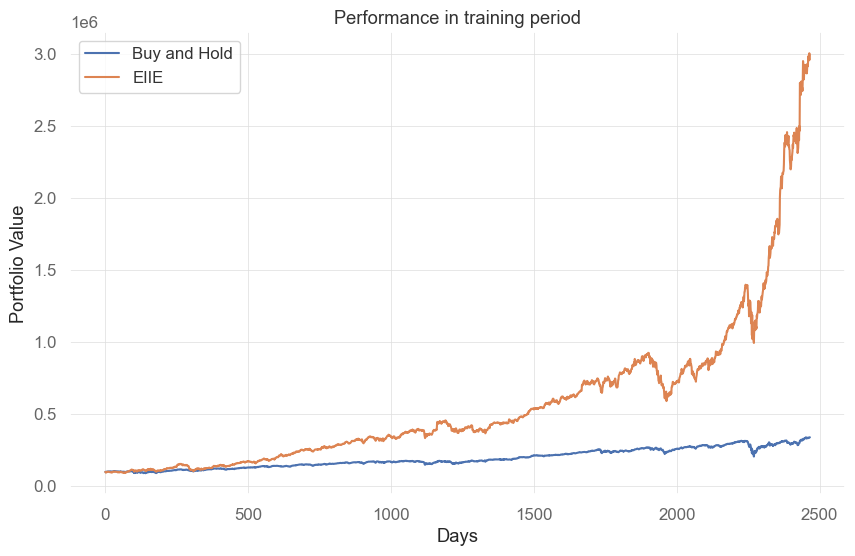

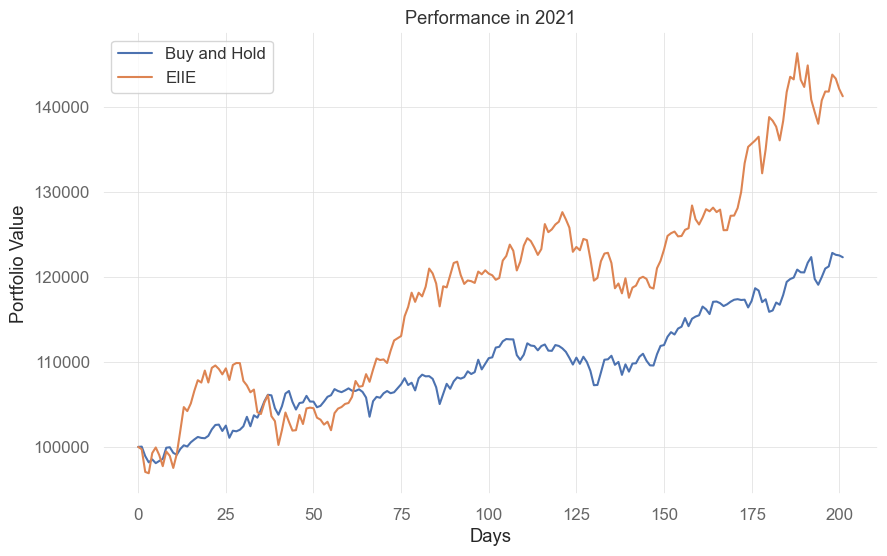

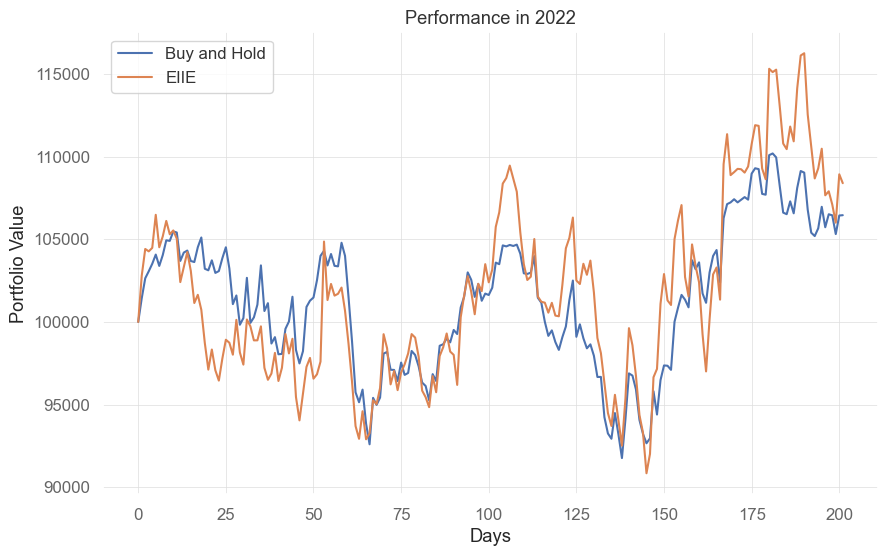

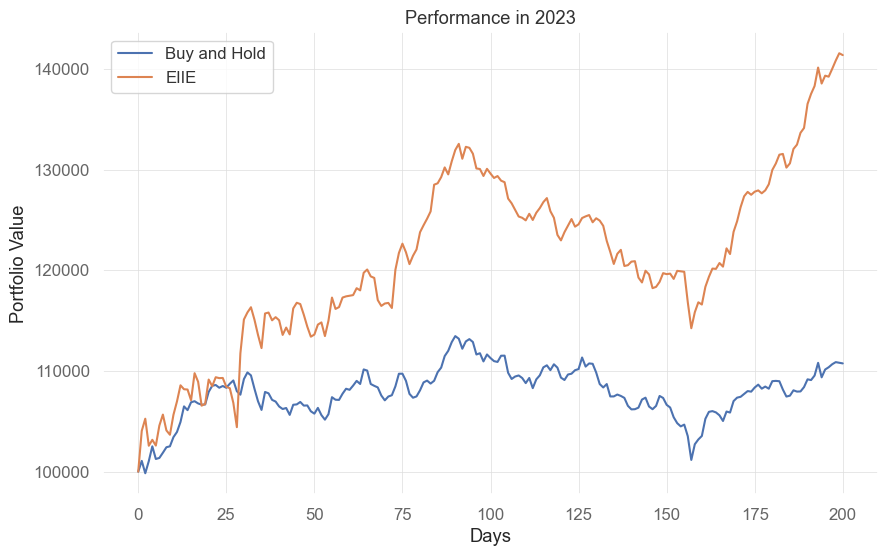

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()